In [1552]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

def watershed(path: str):
    img_src = cv2.imread(path)
    image = cv2.cvtColor(img_src, cv2.COLOR_BGR2GRAY)
    
    plt.rcParams['figure.dpi'] = 90
    
    fig, ax = plt.subplots(1, 1, figsize=(6, 6))
    ax.imshow(image, cmap='gray')
    ax.set_title('grayscale')
    
    # https://docs.opencv.org/4.x/d3/db4/tutorial_py_watershed.html
    ret, thresh = cv2.threshold(image, 0, 255, type=cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    fig, ax = plt.subplots(1, 1, figsize=(6, 6))
    ax.imshow(thresh, cmap='gray')
    ax.set_title('threshold')
    
    
    # eliminate noise
    opening_kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11,11))
    opening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,opening_kernel)
    
    # eliminate holes
    close_kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,3))
    opening = cv2.morphologyEx(opening,cv2.MORPH_CLOSE, close_kernel)
    
    fig, ax = plt.subplots(1, 1, figsize=(6, 6))
    ax.imshow(opening, cmap='gray')
    ax.set_title('eliminated noise & holes')
    
    # sure background area
    kernel = np.ones((3,3),np.uint8)
    sure_bg = cv2.dilate(opening, kernel, iterations=3)
    
    # Finding sure foreground area
    dist_transform = cv2.distanceTransform(opening, distanceType=cv2.DIST_L2, maskSize=5)
    dist_transform = cv2.convertScaleAbs(dist_transform).astype(np.uint8)
    
    _, sure_fg = cv2.threshold(dist_transform, 20, 255, cv2.THRESH_BINARY)
    
    ## BEGIN MANIPULATIONS FOR ADJUSTING SEGMENTS SHAPES
    sure_fg = cv2.erode(sure_fg, kernel, iterations=3) # edges
    kernel1 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5))
    sure_fg = cv2.morphologyEx(sure_fg, cv2.MORPH_CLOSE, kernel1) # if holes
    
    kernel1 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,3))
    sure_fg = cv2.dilate(sure_fg, kernel, iterations=1) # roundness
    ## END
    
    # Finding unknown region
    sure_fg = np.uint8(sure_fg)
    unknown = cv2.subtract(sure_bg,sure_fg)
    
    # plt.rcParams['figure.dpi'] = 150
    fig, ax = plt.subplots(1, 3, figsize=(12, 12))
    ax[0].imshow(sure_bg, cmap='gray')
    ax[0].set_title('sure_bg (black)')
    
    ax[1].imshow(dist_transform, cmap='gray')
    ax[1].set_title('dist_transform')
    
    ax[2].imshow(sure_fg, cmap='gray')
    ax[2].set_title('sure_fg (white)')
    
    # Marker labelling
    ret, markers = cv2.connectedComponents(sure_fg)
    
    # Add one to all labels so that sure background is not 0, but 1
    markers = markers+1
    
    # Now, mark the region of unknown with zero
    markers[unknown==255] = 0
    
    fig, ax = plt.subplots(1, 1, figsize=(6, 6))
    ax.imshow(markers, cmap='jet')
    ax.set_title('unknown (dark blue)')
    
    water_markers = cv2.watershed(img_src, markers)
    result = img_src.copy()
    result[water_markers == -1] = [255,255,255]
    
    fig, ax = plt.subplots(1, 1, figsize=(6, 6))
    ax.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
    ax.set_title('result')

# Test image

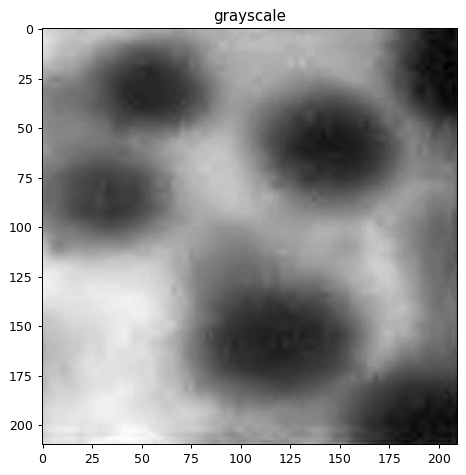

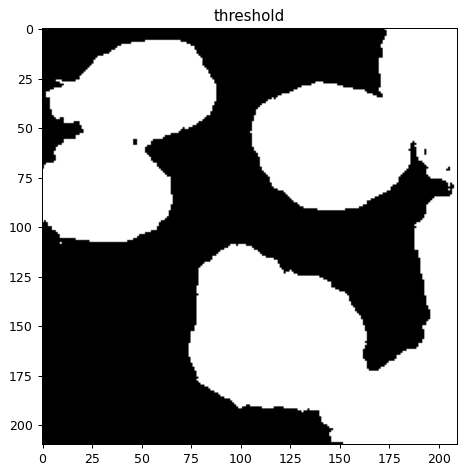

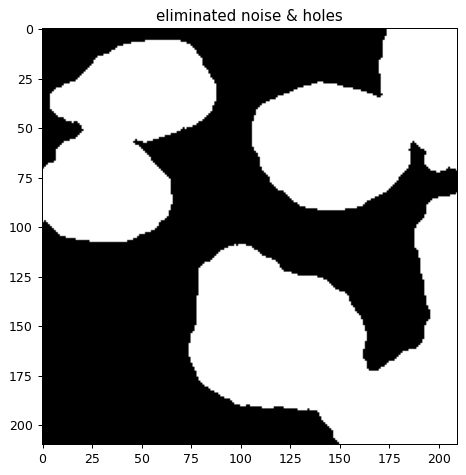

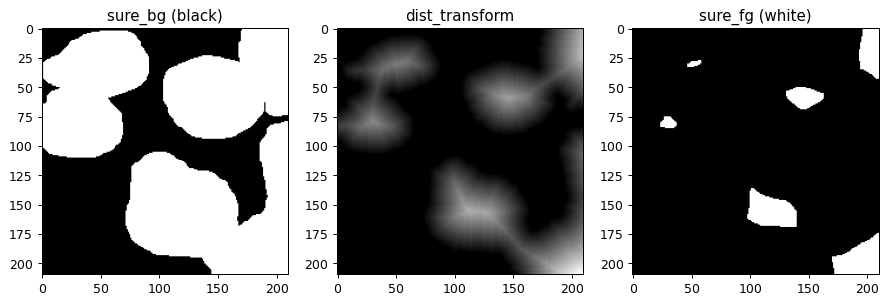

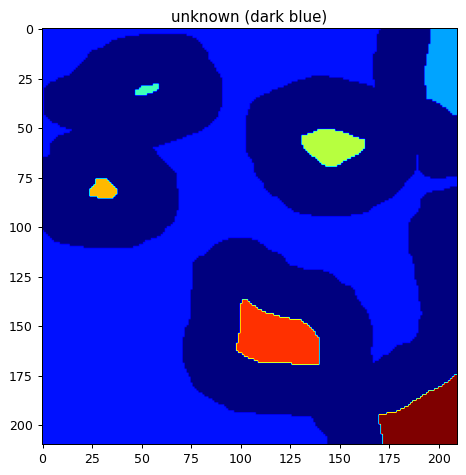

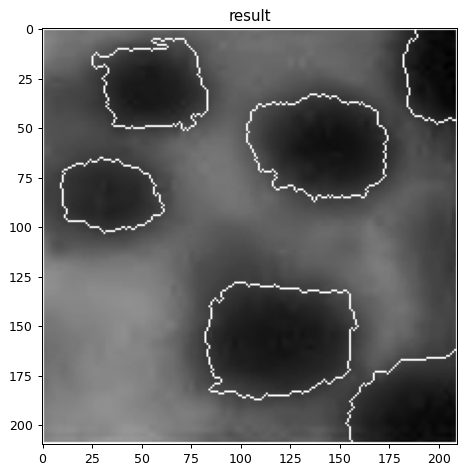

In [1553]:
first_path = './app-data/inputs/cells-01.png'
watershed(first_path)

# Image 02

In [1554]:
plt.rcParams['figure.dpi'] = 90

def ws(img_src: np.ndarray, cleaned_img: np.ndarray, dt_coef: float):
    # sure background area
    kernel = np.ones((3,3),np.uint8)
    sure_bg = cv2.dilate(cleaned_img, kernel, iterations=4)
    # k3 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,3))
    #sure_bg = cv2.dilate(cleaned_img, k3, iterations=4)

    fig, ax = plt.subplots(1, 1, figsize=(6, 6))
    ax.imshow(sure_bg, cmap='gray')
    ax.set_title('sure_bg')
    
    # Finding sure foreground area
    dist_transform: np.ndarray = cv2.distanceTransform(cleaned_img, cv2.DIST_L2, 5)
    fig, ax = plt.subplots(1, 1, figsize=(6, 6))
    ax.imshow(dist_transform, cmap='gray')
    ax.set_title('dist_transform')
    
    _, sure_fg = cv2.threshold(dist_transform, dt_coef * dist_transform.max(), 255, 0) ## dt coeff
    sure_fg = sure_fg.astype(np.uint8)

    fig, ax = plt.subplots(1, 1, figsize=(6, 6))
    ax.imshow(sure_fg, cmap='gray')
    ax.set_title('sure_fg')
    
    # Finding unknown region
    unknown = cv2.subtract(sure_bg, sure_fg)
    
    fig, ax = plt.subplots(1, 1, figsize=(6, 6))
    ax.imshow(unknown, cmap='gray')
    ax.set_title('unknown region')
    
     # Marker labeling
    _, markers = cv2.connectedComponents(sure_fg)
    
    # Add one to all labels so that sure background is not 0, but 1
    markers = markers + 1

    # Now, mark the region of unknown with zero
    markers[unknown == 255] = 0
    
    fig, ax = plt.subplots(1, 1, figsize=(6, 6))
    ax.imshow(markers, cmap='jet')
    ax.set_title('markers')
    
    # Watershed!
    water_markers = cv2.watershed(img_src, markers)
    result = img_src.copy()
    result[water_markers == -1] = [0,0,255]
 
    fig, ax = plt.subplots(1, 1, figsize=(6, 6))
    ax.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
    ax.set_title('result')
    

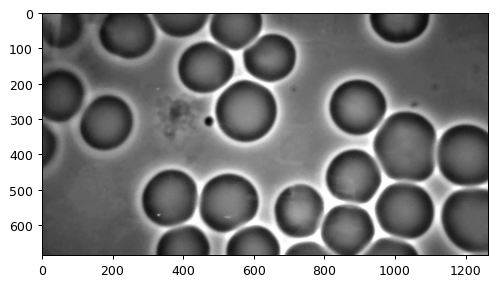

In [1564]:
second_path = './app-data/inputs/ws-02.jpg'
img_src = cv2.imread(second_path)
gs = cv2.cvtColor(img_src, cv2.COLOR_BGR2GRAY)
plt.imshow(gs, cmap='gray')

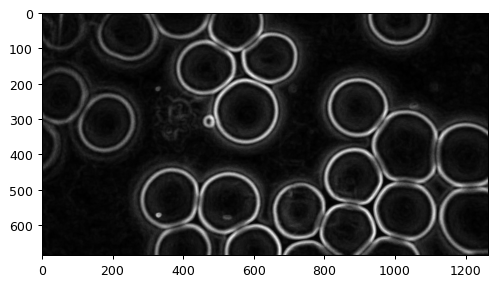

In [1565]:
k9 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (9,9))
cleaned_img = cv2.morphologyEx(gs, cv2.MORPH_GRADIENT, kernel=k9)
plt.imshow(cleaned_img, cmap='gray')

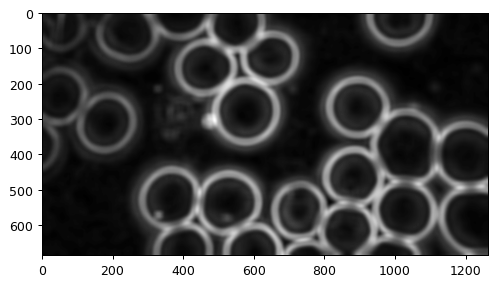

In [1566]:
blur = cv2.blur(cleaned_img, ksize=(21,21))
plt.imshow(blur, cmap='gray')

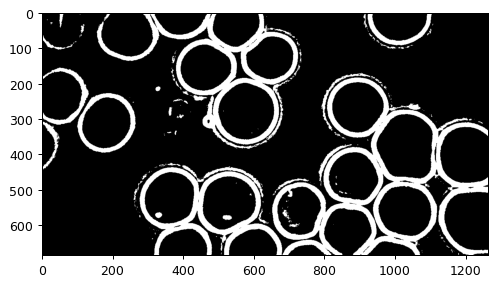

In [1567]:
ret, tres = cv2.threshold(cleaned_img, 30, 255, type=cv2.THRESH_BINARY)
plt.imshow(tres, cmap='gray')

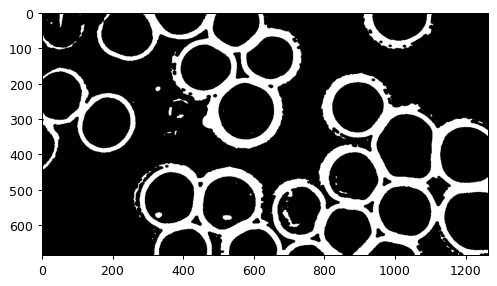

In [1568]:
k41 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (41, 41))
k15 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (15, 15))
k13 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (13, 13))
k11 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11, 11))
k5 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
k3 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))

cleaned_img = cv2.morphologyEx(tres,cv2.MORPH_CLOSE, k5, iterations=2)
plt.imshow(cleaned_img, cmap='gray')

In [1569]:
# cleaned_img = cv2.morphologyEx(cleaned_img,cv2.MORPH_ERODE, k3)
# plt.imshow(cleaned_img, cmap='gray')

# cleaned_img = cv2.morphologyEx(cleaned_img,cv2.MORPH_DILATE, k11)
# plt.imshow(cleaned_img, cmap='gray')

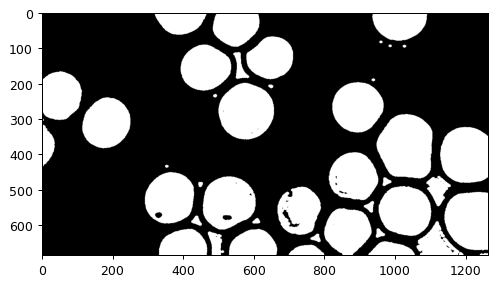

In [1570]:
cv2.bitwise_not(cleaned_img, cleaned_img)
cv2.floodFill(cleaned_img, None, (150, 150), 0)
plt.imshow(cleaned_img, cmap='gray')

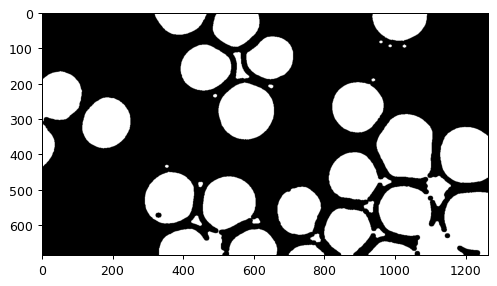

In [1571]:
cleaned_img = cv2.morphologyEx(cleaned_img,cv2.MORPH_CLOSE, k15, iterations=1)
plt.imshow(cleaned_img, cmap='gray')

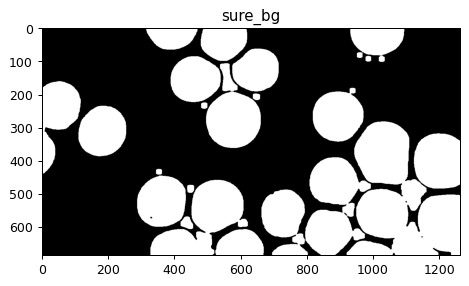

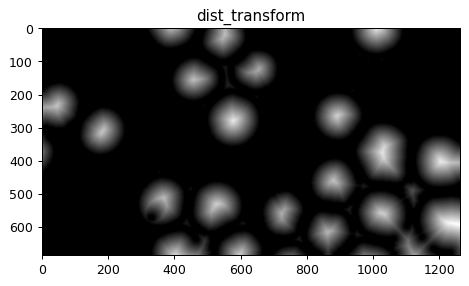

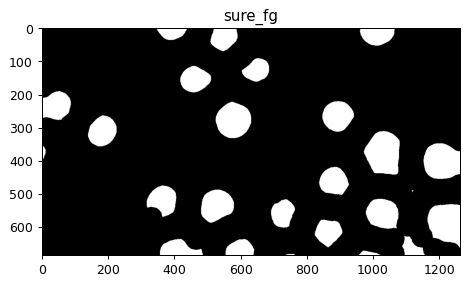

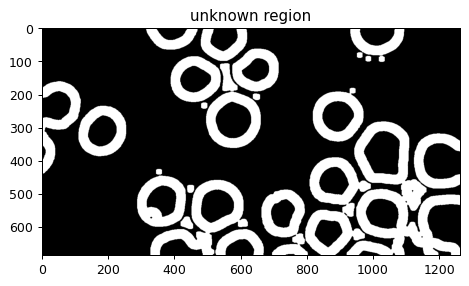

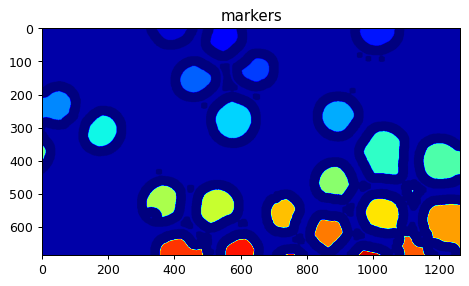

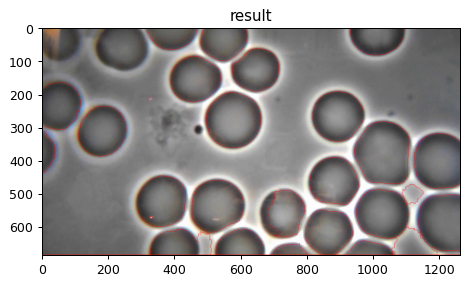

In [1572]:
ws(img_src, cleaned_img, 0.3)